In [344]:
# Useful starting lines
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [374]:
from proj1_helpers import *
DATA_TRAIN_PATH = 'C:\\Users\\asus\\Documents\\GitHub\\ML_course\\projects\\project1\\data\\train.csv' # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

## Do your thing crazy machine learning thing here :) ...

In [375]:
from implementations import *

In [376]:
#Normalize the data
centered_data = tX - np.mean(tX, axis=0)
tX = centered_data / np.std(centered_data, axis=0)
y[y == -1] = 0

In [377]:
#Find the correlations btw all columns and delete rows that are highly correlated
corr_mtx = np.identity(30)
for i in range(31):
    for j in range(i,30):
        corr_mtx[i,j] = np.corrcoef(tX[:,i], tX[:,j])[0,1]
        if corr_mtx[i,j]>0.95 and i!=j:
            print(i,j)

4 6
4 12
4 26
4 27
4 28
6 12
6 26
6 27
6 28
9 29
12 26
12 27
12 28
23 24
23 25
24 25
26 27
26 28
27 28


In [378]:
tX = np.delete(tX, np.array([6, 12,24,25,26,27,28,29]), axis=1)

In [379]:
least_squares_GD(y, tX, np.ones(tX.shape[1]), 50, 0.3)

(array([ 4.74321259e-02, -1.53963212e-01, -1.37635737e-01,  1.33744517e-01,
         8.92468835e-02,  2.69903296e-01,  7.71949367e-02,  6.08511647e-02,
         4.22754698e-02,  1.54108065e-03,  1.38481014e-01,  2.28383070e-01,
         4.78779208e-04,  1.48033753e-04,  1.33319320e-01,  1.64120780e-03,
         9.00020726e-04,  1.25322046e-01,  1.80818705e-03,  8.89206402e-02,
         1.77560082e-02,  1.94047648e-01]), 1.2071598609650507)

0.7908063419107262

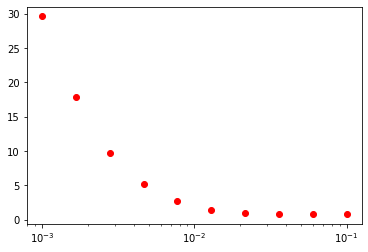

In [112]:
num_gamma = 10
least_squares_loss = np.ones(num_gamma)
gamma = np.logspace(-3, -1, num_gamma)
for i in range(num_gamma):
    least_squares_loss[i] = least_squares_GD(y, tX, np.ones(tX.shape[1]), 100, gamma[i])[1]
plt.plot(gamma, least_squares_loss, 'ro')
plt.xscale('log')
np.min(least_squares_loss)

In [380]:
least_squares_SGD(y, tX, np.ones(tX.shape[1]), 1, 200, 0.3)

(array([-1.40936086e+36,  1.06878612e+37,  1.70896149e+37, -1.01773818e+37,
         8.22331293e+36,  7.28824773e+36,  5.65061120e+36, -4.43350904e+36,
        -2.94339654e+36, -4.52477797e+36, -1.65454046e+37,  6.94338847e+36,
         5.67323609e+36, -1.94235704e+36,  3.29168178e+36,  1.24434164e+37,
         1.59896493e+37, -1.32440593e+36,  1.28192696e+37,  4.39896734e+35,
         1.99278865e+36, -1.37899137e+37]), 2.6199367420757343e+75)

1.03736747240533

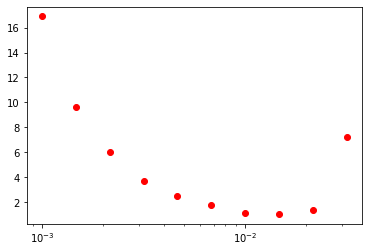

In [116]:
num_gamma = 10
least_squares_loss_SG = np.ones(num_gamma)
gamma = gamma = np.logspace(-3, -1.5, num_gamma)
for i in range(num_gamma):
    least_squares_loss_SG[i] = least_squares_SGD(y, tX, np.ones(tX.shape[1]), 1, 200, gamma[i])[1]
plt.plot(gamma, least_squares_loss_SG, 'ro')
plt.xscale('log')
np.min(least_squares_loss_SG)

In [381]:
least_squares(y, tX)

(array([ 0.01457775, -0.12673899, -0.12745413, -0.01694001, -0.08993026,
         0.20927023,  0.13388932, -0.00050725, -0.07308316, -0.09132203,
         0.05763819,  0.11023857, -0.00032171, -0.00054586,  0.15797759,
        -0.00043332,  0.0012556 ,  0.06044576,  0.00050283, -0.03165107,
        -0.09071907,  0.07996976]), 0.28744464469757697)

In [382]:
ridge_regression(y, tX, 0.1)

(array([ 0.02928944, -0.09134654, -0.04128843,  0.0157347 , -0.00789187,
         0.06632467,  0.05839849, -0.01675251, -0.0095126 , -0.04606021,
         0.05316168,  0.068482  , -0.00052348, -0.00098303,  0.04365018,
        -0.00033499,  0.0011042 ,  0.0203309 ,  0.00078524, -0.02369181,
        -0.03046628,  0.01630215]), 0.2977087987665188)

0.7791136192054087

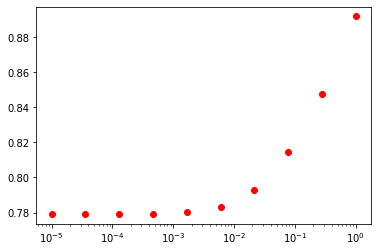

In [121]:
num_lambda = 10
ridge_regression_loss = np.ones(num_lambda)
lambda_ =  np.logspace(-5, 0, num_lambda)
for i in range(num_lambda):
    ridge_regression_loss[i] = ridge_regression(y, tX, lambda_[i])[1]
plt.plot(lambda_, ridge_regression_loss, 'ro')
plt.xscale('log')
np.min(ridge_regression_loss)

In [424]:
from implementations import *

In [426]:
logistic_regression(y[0:10000], tX[0:10000])

Current iteration=0, loss=[6931.4718056]
Current iteration=100, loss=[nan]
Current iteration=200, loss=[nan]
Current iteration=300, loss=[nan]
Current iteration=400, loss=[nan]
Current iteration=500, loss=[nan]
Current iteration=600, loss=[nan]
Current iteration=700, loss=[nan]
Current iteration=800, loss=[nan]
Current iteration=900, loss=[nan]
Current iteration=1000, loss=[nan]
Current iteration=1100, loss=[nan]
Current iteration=1200, loss=[nan]
Current iteration=1300, loss=[nan]
Current iteration=1400, loss=[nan]
Current iteration=1500, loss=[nan]
Current iteration=1600, loss=[nan]
Current iteration=1700, loss=[nan]
Current iteration=1800, loss=[nan]
Current iteration=1900, loss=[nan]
Current iteration=2000, loss=[nan]
Current iteration=2100, loss=[nan]
Current iteration=2200, loss=[nan]
Current iteration=2300, loss=[nan]
Current iteration=2400, loss=[nan]
Current iteration=2500, loss=[nan]
Current iteration=2600, loss=[nan]
Current iteration=2700, loss=[nan]
Current iteration=2800,

(array([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan]]), array([nan]))

## Generate predictions and save ouput in csv format for submission:

In [10]:
DATA_TEST_PATH = '' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [31]:
OUTPUT_PATH = '' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)